## Module importing

In [3]:
import pandas as pd
import numpy as np

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [5]:
%matplotlib inline

## Data loading

1. Age of patient at time of operation (numerical)
2. Patient's year of operation (year - 1900, numerical)
3. Number of positive axillary nodes detected (numerical)
4. Survival status (class attribute)
    + 1 = the patient survived 5 years or longer
    + 2 = the patient died within 5 year

In [6]:
data = pd.read_csv('data/haberman.data', header=None)
data.columns = ['age', 'operation_year', 'np_nodes', 'survival']
data.shape

(306, 4)

## Simple data preprocessing

In [7]:
data.survival = data.survival.map({1: 1, 2: 0})

_Перетворiть на фактор колонку Age - до 30 рокiв, 30-60, бiльше 60_

**Оскільки в датасеті немає записів про пацієнтів з віком < 30, тому будемо використовувати наступні розпоідли:**
+ до 40
+ 40-60
+ більше 60

In [8]:
data.age = data.age.apply(lambda x: '< 40' if x < 40 else '> 60' if x > 60 else '40-60')

## I PART

**Опрацювати данi на предмет пропущених значень.**

## EDA

In [9]:
data.head()

,age,operation_year,np_nodes,survival
0,< 40,64,1,1
1,< 40,62,3,1
2,< 40,65,0,1
3,< 40,59,2,1
4,< 40,65,4,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             306 non-null    object
 1   operation_year  306 non-null    int64 
 2   np_nodes        306 non-null    int64 
 3   survival        306 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 9.7+ KB


**Як бачимо, в наших даних відсутні пропущені значення**

In [11]:
data.describe()

,operation_year,np_nodes,survival
count,306.000000,306.000000,306.000000
mean,62.852941,4.026144,0.735294
std,3.249405,7.189654,0.441899
min,58.000000,0.000000,0.000000
25%,60.000000,0.000000,0.000000
50%,63.000000,1.000000,1.000000
75%,65.750000,4.000000,1.000000
max,69.000000,52.000000,1.000000


In [12]:
data['survival'].value_counts()

1    225
0     81
Name: survival, dtype: int64

**Цільова змінна є незбалансованою. Для покращення результату можна спробувати виконати балансування класів.**

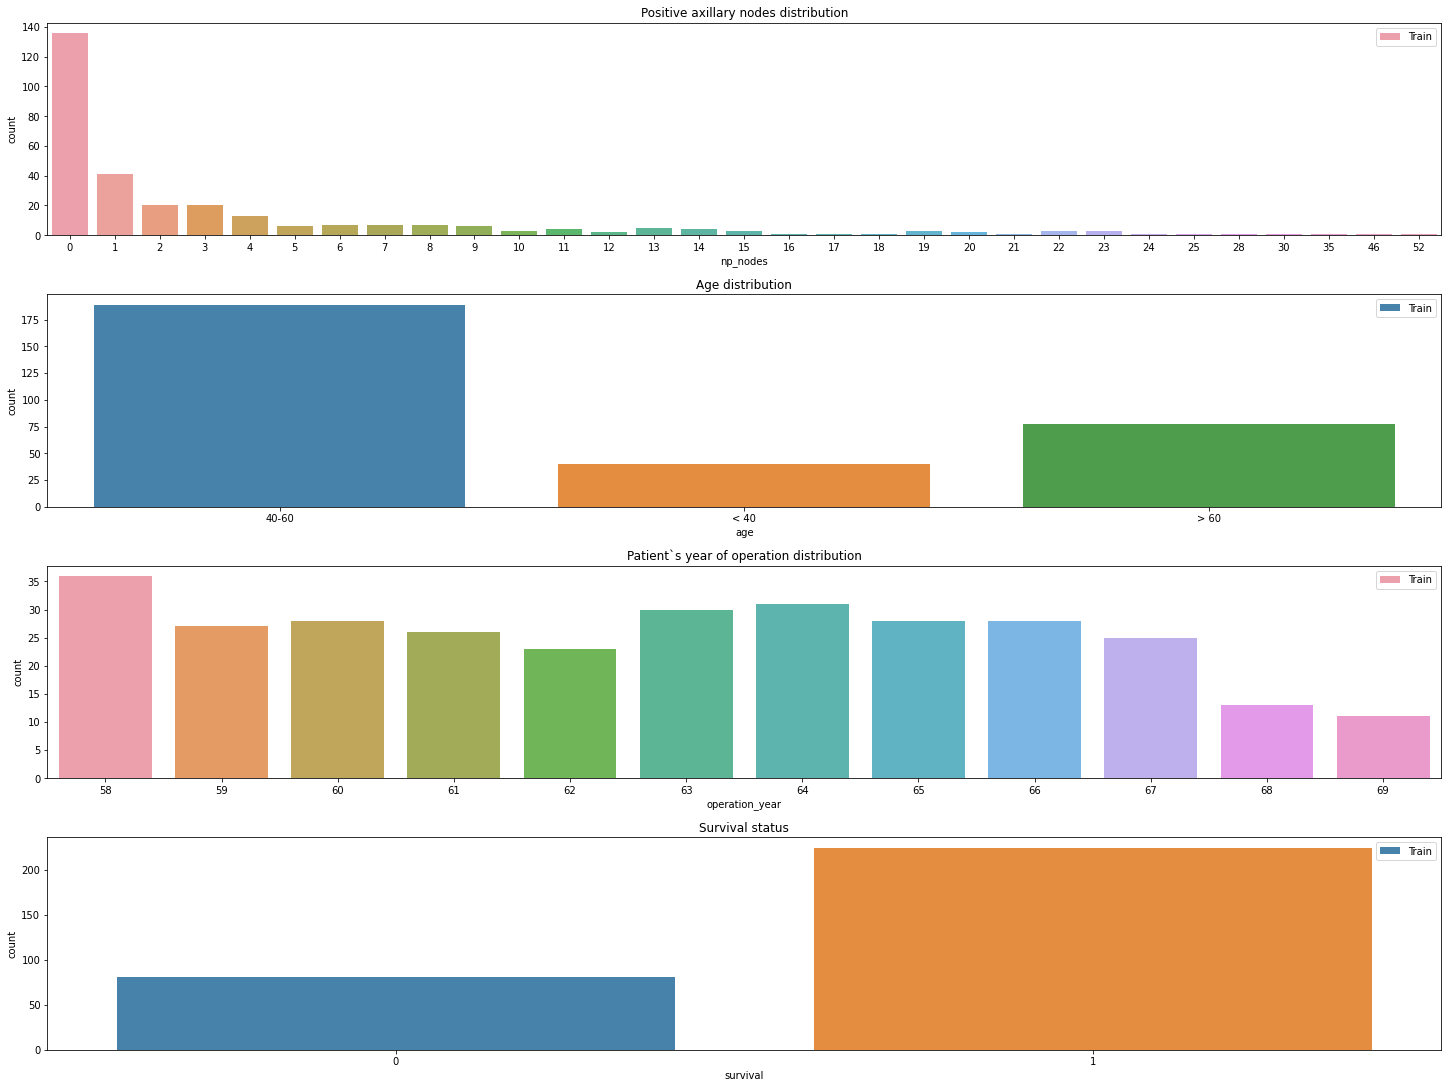

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(20, 15))

# Creating a grid:

grid = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)

ax1 = fig.add_subplot(grid[0,:])

# Set the title.

ax1.set_title('Positive axillary nodes distribution')

sns.countplot(data.np_nodes.sort_values(ignore_index=True),
              alpha=0.9,
              ax=ax1,
              label='Train')
ax1.legend()



ax2 = fig.add_subplot(grid[1, :])

# Set the title.

ax2.set_title('Age distribution')

# Plot the histogram.

sns.countplot(data.age.sort_values(ignore_index=True),
              alpha=0.9,
              ax=ax2,
              label='Train')

ax2.legend()



ax3 = fig.add_subplot(grid[2,:])

# Set the title.

ax3.set_title('Patient`s year of operation distribution')

sns.countplot(data.operation_year.sort_values(ignore_index=True),
              alpha=0.9,
              ax=ax3,
              label='Train')
ax3.legend()



ax4 = fig.add_subplot(grid[3,:])

# Set the title.

ax4.set_title('Survival status')

sns.countplot(data.survival.sort_values(ignore_index=True),
              alpha=0.9,
              ax=ax4,
              label='Train')
ax4.legend()


plt.show()


<AxesSubplot:>

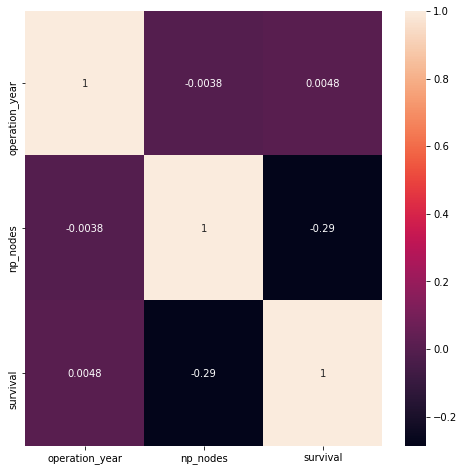

In [15]:
f, ax = plt.subplots(1,1, figsize=(8,8))
sns.heatmap(data.corr(), annot=True, ax=ax)

<AxesSubplot:>

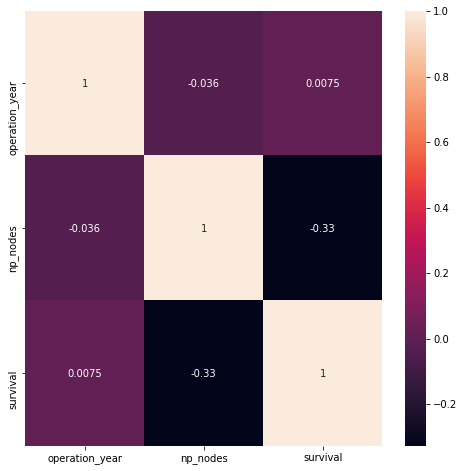

In [17]:
f, ax = plt.subplots(1,1, figsize=(8,8))
sns.heatmap(data.corr(method='spearman'), annot=True, ax=ax)

## II - IV PARTS

**Побудувати наївний байєсiвський класифiкатор.**

**Провести класифiкацiю методом k-nn, спробуйте рiзнi значення n.**

**Провести класифiкацiю за допомогою логiстичної регресiї.**

## Data preparation

In [264]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [265]:
scaler = StandardScaler()

In [266]:
X = data.drop(['survival', 'age'], axis=1)
y = data['survival']

In [267]:
X = scaler.fit_transform(X)

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## Model building

### Naive bayes

In [269]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, classification_report

**В якості метрики якості будемо використовувати roc-auc**

In [270]:
nb = GaussianNB()

In [271]:
nb.fit(X_train, y_train)

GaussianNB()

In [272]:
predict_nb_train = nb.predict_proba(X_train)[:, 1]
predict_nb_test = nb.predict_proba(X_test)[:, 1]

In [273]:
print(f'(train|NB) roc-auc = {roc_auc_score(y_train, predict_nb_train)}')
print(f'(test|NB) roc-auc = {roc_auc_score(y_test, predict_nb_test)}')

(train|NB) roc-auc = 0.7058668771375954
(test|NB) roc-auc = 0.5707070707070707


In [274]:
print('Test set report')
print(classification_report(y_test, predict_nb_test.round()))

Test set report
              precision    recall  f1-score   support

           0       0.50      0.22      0.31        18
           1       0.74      0.91      0.82        44

    accuracy                           0.71        62
   macro avg       0.62      0.57      0.56        62
weighted avg       0.67      0.71      0.67        62



**Бачимо, що дана модель показує поганий результат на тестовій вибірці, якщо порівнювати з результатом на навчальній вибірці. Можемо зробити висновок, що модель перенавчилась.**

### K-NN

In [275]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

**Для пошуку найкращого значення параметра n_neighbors використаємо GridSearchCV**

In [276]:
parameters = {'n_neighbors': np.arange(2, 10)}

In [277]:
knn = KNeighborsClassifier()

In [278]:
knn_grid = GridSearchCV(knn, parameters, cv=5)

#fit the grid search
knn_grid.fit(X_train, y_train)

# best model
best_model_knn = knn_grid.best_estimator_
best_model_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

In [279]:
predict_knn_test = best_model_knn.predict_proba(X_test)[:, 1]
predict_knn_train = best_model_knn.predict_proba(X_train)[:, 1]

In [280]:
print(f'(train|KNN) roc-auc = {roc_auc_score(y_train, predict_knn_train)}')
print(f'(test|KNN) roc-auc = {roc_auc_score(y_test, predict_knn_test)}')

(train|KNN) roc-auc = 0.7588353941945103
(test|KNN) roc-auc = 0.67739898989899


In [281]:
print('Test set report')
print(classification_report(y_test, predict_knn_test.round()))

Test set report
              precision    recall  f1-score   support

           0       0.50      0.33      0.40        18
           1       0.76      0.86      0.81        44

    accuracy                           0.71        62
   macro avg       0.63      0.60      0.60        62
weighted avg       0.68      0.71      0.69        62



**Результат все на тестовій вибірці покращився, але модель досі перенавчається.**

### Logistic Regression

In [282]:
from sklearn.linear_model import LogisticRegression

In [283]:
lr = LogisticRegression()

In [284]:
lr.fit(X_train, y_train)

LogisticRegression()

In [285]:
predict_lr_train = lr.predict_proba(X_train)[:, 1]
predict_lr_test = lr.predict_proba(X_test)[:, 1]

In [286]:
print(f'(train|LR) roc-auc = {roc_auc_score(y_train, predict_lr_train)}')
print(f'(test|LR) roc-auc = {roc_auc_score(y_test, predict_lr_test)}')

(train|LR) roc-auc = 0.7184074366394808
(test|LR) roc-auc = 0.5984848484848485


In [287]:
print('Test set report')
print(classification_report(y_test, predict_lr_test.round()))

Test set report
              precision    recall  f1-score   support

           0       0.50      0.17      0.25        18
           1       0.73      0.93      0.82        44

    accuracy                           0.71        62
   macro avg       0.62      0.55      0.53        62
weighted avg       0.66      0.71      0.65        62



**Результат роботи логістичної є кращим, ніж Naive bayes, але гіршим за K-NN**

## V PART

**Додайте до моделi факторнi данi. Для цього можна скористатися рiзними технiками: присвоїти кожному фактору деяке число i проводити звичайний аналiз (для яких методiв цей пiдхiд може спрацювати краще?), iнший пiдхiд полягає у тому щоб розбити вибiрку на пiдвибiрки по кожному значенню фактора i аналiзувати пiдвибiрки окремо.**

**Спробуємо застосувати метод кодування категоріальних змінних під назвою OneHotEncoder (він добре підходить для моделей, які показують гарний результат при роботі з розрідженими даними) та MeanEncoding (кодування середнім по цільовому класу)**

**Отже, застосуємо наступні техніки кодування для алгоритмів:**
+ Naive bayes - MeanEncoding
+ K-NN - MeanEncoding
+ Logistic Regression - OneHotEncoding

**P.S. Кодування категоріальних зміних довільним числом добре підійде для алгоритмів, які працюють на основі дерева прийняття рішень. В нашому випадку, кодуючи категоріальні змінні довільними числами ми будем вносити поняття величини та порядку, що вплине на роботу метричних алгоритмів.**

## Data preparation

In [318]:
def encode_target_smooth(data, target, categ_variables, smooth):
    """    
    Apply target encoding with smoothing.
    
    Parameters
    ----------
    data: pd.DataFrame
    target: str, dependent variable
    categ_variables: list of str, variables to encode
    smooth: int, number of observations to weigh global average with
    
    Returns
    --------
    encoded_dataset: pd.DataFrame
    code_map: dict, mapping to be used on validation/test datasets 
    defaul_map: dict, mapping to replace previously unseen values with
    """
    train_target = data.copy()
    code_map = dict()    # stores mapping between original and encoded values
    default_map = dict() # stores global average of each variable
    
    for v in categ_variables:
        prior = data[target].mean()
        n = data.groupby(v).size()
        mu = data.groupby(v)[target].mean()
        mu_smoothed = (n * mu + smooth * prior) / (n + smooth)
        
        train_target.loc[:, v] = train_target[v].map(mu_smoothed)        
        code_map[v] = mu_smoothed
        default_map[v] = prior        
    return train_target, code_map, default_map

In [319]:
scaler = StandardScaler()

In [320]:
X, _, _ = encode_target_smooth(data, 'survival', ['age'], 300)
X = X.drop(['survival'], axis=1)

In [321]:
y = data['survival']

In [322]:
X = scaler.fit_transform(X)

In [323]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## Model building

### Naive bayes

In [324]:
nb = GaussianNB()

In [325]:
nb.fit(X_train, y_train)

GaussianNB()

In [326]:
predict_nb_train = nb.predict_proba(X_train)[:, 1]
predict_nb_test = nb.predict_proba(X_test)[:, 1]

In [327]:
print(f'(train|NB) roc-auc = {roc_auc_score(y_train, predict_nb_train)}')
print(f'(test|NB) roc-auc = {roc_auc_score(y_test, predict_nb_test)}')

(train|NB) roc-auc = 0.7116548276769271
(test|NB) roc-auc = 0.5921717171717171


In [328]:
print('Test set report')
print(classification_report(y_test, predict_nb_test.round()))

Test set report
              precision    recall  f1-score   support

           0       0.57      0.22      0.32        18
           1       0.75      0.93      0.83        44

    accuracy                           0.73        62
   macro avg       0.66      0.58      0.57        62
weighted avg       0.69      0.73      0.68        62



**Результат трохи покращився, в порівнянні з попереднім**

### K-NN

In [329]:
parameters = {'n_neighbors': np.arange(2, 10)}

In [330]:
knn = KNeighborsClassifier()

In [331]:
knn_grid = GridSearchCV(knn, parameters, cv=5)

#fit the grid search
knn_grid.fit(X_train, y_train)

# best model
best_model_knn = knn_grid.best_estimator_
best_model_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [332]:
predict_knn_test = best_model_knn.predict_proba(X_test)[:, 1]
predict_knn_train = best_model_knn.predict_proba(X_train)[:, 1]

In [333]:
print(f'(train|KNN) roc-auc = {roc_auc_score(y_train, predict_knn_train)}')
print(f'(test|KNN) roc-auc = {roc_auc_score(y_test, predict_knn_test)}')

(train|KNN) roc-auc = 0.8063228974831184
(test|KNN) roc-auc = 0.6704545454545455


In [334]:
print('Test set report')
print(classification_report(y_test, predict_knn_test.round()))

Test set report
              precision    recall  f1-score   support

           0       0.50      0.22      0.31        18
           1       0.74      0.91      0.82        44

    accuracy                           0.71        62
   macro avg       0.62      0.57      0.56        62
weighted avg       0.67      0.71      0.67        62



**Результат на тестовій вибірці трохи погіршився, а на навчальній покращився**

## Data preparation

In [306]:
def one_hot_enc(df):
    encode_col_list = list(df.select_dtypes(include=['object']).columns)
    for i in encode_col_list:
        df = pd.concat([df,pd.get_dummies(df[i], prefix=i)],axis=1)
        df.drop(i, axis = 1, inplace=True)
    
    return df

In [307]:
scaler = StandardScaler()

In [308]:
X = data.drop(['survival', 'age'], axis=1)
y = data['survival']
categorical = data[['age']]

In [309]:
categorical = one_hot_enc(categorical).values

In [310]:
X = scaler.fit_transform(X)

In [311]:
X = np.hstack((X, categorical))

In [312]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## Model building

### Logistic Regression

In [313]:
lr = LogisticRegression()

In [314]:
lr.fit(X_train, y_train)

LogisticRegression()

In [315]:
predict_lr_train = lr.predict_proba(X_train)[:, 1]
predict_lr_test = lr.predict_proba(X_test)[:, 1]

In [316]:
print(f'(train|LR) roc-auc = {roc_auc_score(y_train, predict_lr_train)}')
print(f'(test|LR) roc-auc = {roc_auc_score(y_test, predict_lr_test)}')

(train|LR) roc-auc = 0.7542751907392791
(test|LR) roc-auc = 0.5808080808080809


In [317]:
print('Test set report')
print(classification_report(y_test, predict_lr_test.round()))

Test set report
              precision    recall  f1-score   support

           0       0.43      0.17      0.24        18
           1       0.73      0.91      0.81        44

    accuracy                           0.69        62
   macro avg       0.58      0.54      0.52        62
weighted avg       0.64      0.69      0.64        62



**Результат на тестовій вибірці погіршився, а на навчальній покращився**